In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
DATASET_ROOT = Path("/content/drive/MyDrive/synapse_2d_dataset")

for split in ["train", "val", "test"]:
    for cls in ["inhibitory", "excitatory"]:
        p = DATASET_ROOT / split / cls
        print(p, "exists:", p.exists())



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/synapse_2d_dataset/train/inhibitory exists: True
/content/drive/MyDrive/synapse_2d_dataset/train/excitatory exists: True
/content/drive/MyDrive/synapse_2d_dataset/val/inhibitory exists: True
/content/drive/MyDrive/synapse_2d_dataset/val/excitatory exists: True
/content/drive/MyDrive/synapse_2d_dataset/test/inhibitory exists: True
/content/drive/MyDrive/synapse_2d_dataset/test/excitatory exists: True


In [ ]:
def count_images(p):
    return sum(1 for _ in p.glob("*.png"))

for split in ["train", "val", "test"]:
    c0 = count_images(DATASET_ROOT / split / "inhibitory")
    c1 = count_images(DATASET_ROOT / split / "excitatory")
    print(f"{split}: inhibitory={c0}, excitatory={c1}, total={c0+c1}")


train: inhibitory=1500, excitatory=1500, total=3000
val: inhibitory=225, excitatory=225, total=450
test: inhibitory=225, excitatory=225, total=450


In [ ]:
# CELL 1 — Imports + dataset root (Colab)

from pathlib import Path
import os, random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# This is my ACTUAL dataset location in Colab
DATASET_ROOT = Path("/content/drive/MyDrive/synapse_2d_dataset")

print("DATASET_ROOT exists:", DATASET_ROOT.exists())
print("Contents:", [p.name for p in DATASET_ROOT.iterdir()])


DATASET_ROOT exists: True
Contents: ['val', 'test', 'train']


[DATASET_ROOT] /content/drive/MyDrive/synapse_2d_dataset
[CHECK] Folder existence + image counts:

  train/inhibitory  | exists=True | pngs=1500
  train/excitatory  | exists=True | pngs=1500
  --> train total: 3000

    val/inhibitory  | exists=True | pngs=225
    val/excitatory  | exists=True | pngs=225
  --> val total: 450

   test/inhibitory  | exists=True | pngs=225
   test/excitatory  | exists=True | pngs=225
  --> test total: 450

[TOTAL] images across train/val/test: 3900

[SAMPLES] Displaying a few random images (if available)...


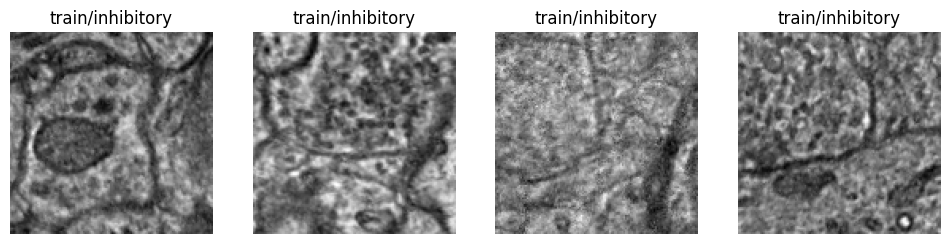

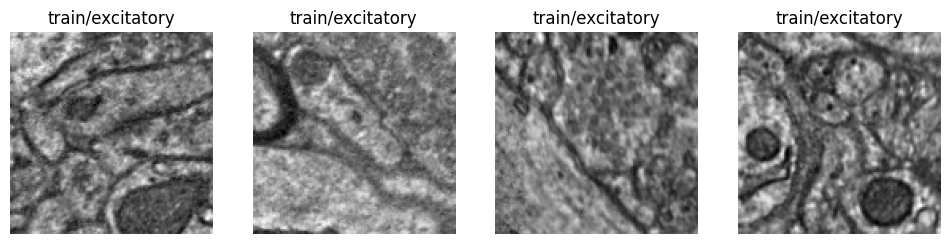

In [ ]:
# ================= CELL 3 — 2D DATASET VERIFY =================

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import random

# ---- Set 2D dataset root here ----
DATASET_ROOT = Path("/content/drive/MyDrive/synapse_2d_dataset")

splits = ["train", "val", "test"]
classes = ["inhibitory", "excitatory"]

print(f"[DATASET_ROOT] {DATASET_ROOT}")
print("[CHECK] Folder existence + image counts:\n")

def count_pngs(folder: Path) -> int:
    if not folder.exists():
        return 0
    return sum(1 for _ in folder.glob("*.png"))

# 1) Count images per split/class
total_all = 0
for split in splits:
    split_total = 0
    for cls in classes:
        p = DATASET_ROOT / split / cls
        n = count_pngs(p)
        split_total += n
        print(f"  {split:>5}/{cls:<11} | exists={p.exists()} | pngs={n}")
    total_all += split_total
    print(f"  --> {split} total: {split_total}\n")

print(f"[TOTAL] images across train/val/test: {total_all}")

# 2) Show random samples (sanity check)
def show_samples(split="train", cls="inhibitory", k=4):
    p = DATASET_ROOT / split / cls
    imgs = list(p.glob("*.png"))
    if len(imgs) == 0:
        print(f"[SAMPLES] No PNGs found in: {p}")
        return
    picks = random.sample(imgs, min(k, len(imgs)))

    plt.figure(figsize=(3*len(picks), 3))
    for i, fp in enumerate(picks, 1):
        im = Image.open(fp).convert("RGB")
        plt.subplot(1, len(picks), i)
        plt.imshow(im)
        plt.axis("off")
        plt.title(f"{split}/{cls}")
    plt.show()

print("\n[SAMPLES] Displaying a few random images (if available)...")
show_samples("train", "inhibitory", k=4)
show_samples("train", "excitatory", k=4)



In [ ]:
# ================= CELL 4 — Build train/val/test FILE LISTS from PNG folders =================
from pathlib import Path
import random

SEED = 42
random.seed(SEED)

DATASET_ROOT = Path("/content/drive/MyDrive/synapse_2d_dataset")

label_map = {
    "inhibitory": 0,
    "excitatory": 1
}

def collect_items(split):
    items = []
    for cls, y in label_map.items():
        folder = DATASET_ROOT / split / cls
        if not folder.exists():
            raise FileNotFoundError(f"Missing folder: {folder}")
        for p in folder.glob("*.png"):
            items.append((p, y))
    return items

train_items = collect_items("train")
val_items   = collect_items("val")
test_items  = collect_items("test")

random.shuffle(train_items)

print("Train items:", len(train_items))
print("Val items:  ", len(val_items))
print("Test items: ", len(test_items))

# sanity check
assert len(train_items) > 0, "Train set empty"
assert len(val_items) > 0, "Val set empty"
assert len(test_items) > 0, "Test set empty"


Train items: 3000
Val items:   450
Test items:  450


In [ ]:
# ================= CELL 5 — Dataset + transforms (uses train_items/val_items/test_items) =================
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

train_tfms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_tfms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

class PngListDataset(Dataset):
    def __init__(self, items, transform=None):
        self.items = items  # list of (filepath, label_int)
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, i):
        fp, y = self.items[i]
        img = Image.open(fp).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(y, dtype=torch.long)

train_ds = PngListDataset(train_items, transform=train_tfms)
val_ds   = PngListDataset(val_items,   transform=val_tfms)
test_ds  = PngListDataset(test_items,  transform=val_tfms)

print("Datasets:", len(train_ds), len(val_ds), len(test_ds))


Datasets: 3000 450 450


In [ ]:
# ================= CELL 6 — DataLoaders + class weights =================
from torch.utils.data import DataLoader
import numpy as np
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 32
NUM_WORKERS = 2

train_ld = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Compute class balance from train_items list
y_train = np.array([y for _, y in train_items], dtype=int)
c0 = int((y_train == 0).sum())
c1 = int((y_train == 1).sum())

w0 = (c0 + c1) / (2 * max(1, c0))
w1 = (c0 + c1) / (2 * max(1, c1))

class_weights = torch.tensor([w0, w1], dtype=torch.float32).to(DEVICE)

print("Train counts:", {"inhibitory(0)": c0, "excitatory(1)": c1})
print("Class weights:", class_weights)


Train counts: {'inhibitory(0)': 1500, 'excitatory(1)': 1500}
Class weights: tensor([1., 1.], device='cuda:0')


In [ ]:
# ================= CELL 7 — Build model (ResNet18/50) =================
import torch
import torch.nn as nn
from torchvision import models

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLASSES = 2  # inhibitory vs excitatory

# Choose backbone
BACKBONE = "resnet50"  # options: "resnet18", "resnet50"

if BACKBONE == "resnet18":
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
elif BACKBONE == "resnet50":
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
else:
    raise ValueError("Unsupported BACKBONE")

# Replace final layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

model = model.to(DEVICE)

# Optional: freeze early layers for stability (good if dataset small)
FREEZE_BACKBONE = False
if FREEZE_BACKBONE:
    for name, param in model.named_parameters():
        if not name.startswith("fc."):
            param.requires_grad = False

print("Model ready on:", DEVICE)
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 241MB/s]


Model ready on: cuda
Trainable params: 23512130


In [ ]:
# ================= CELL 8 — Loss/Optimizer/Scheduler/Scaler =================
import torch
import torch.nn as nn

EPOCHS = 12
LR = 3e-4
WEIGHT_DECAY = 1e-4

# If class_weights exists use it, else default
if "class_weights" in globals():
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print("Using weighted CrossEntropyLoss:", class_weights.detach().cpu().numpy())
else:
    criterion = nn.CrossEntropyLoss()
    print("Using unweighted CrossEntropyLoss")

optimizer = torch.optim.AdamW(
    (p for p in model.parameters() if p.requires_grad),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)

# Simple scheduler (stable)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# AMP scaler
use_amp = (DEVICE == "cuda")
from torch.cuda.amp import GradScaler
scaler = GradScaler(enabled=use_amp)

print("Optimizer/scheduler/scaler ready.")


Using weighted CrossEntropyLoss: [1. 1.]
Optimizer/scheduler/scaler ready.


/tmp/ipython-input-2179003980.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


In [ ]:
# ================= CELL 9 — Warmup + Unfreeze + MixUp + Cosine LR + safe checkpoint (PyTorch 2.6+) =================
import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix, classification_report

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --------- Settings ----------
BEST_PATH = "/content/drive/MyDrive/synapse_resnet2d_best.pt"
EPOCHS_TOTAL = 18          # try 18–30
WARMUP_EPOCHS = 3          # train only head first
LR_HEAD = 3e-4
LR_BACKBONE = 8e-5         # lower than head
WD = 1e-4
LABEL_SMOOTH = 0.05
PATIENCE = 6
TAUS = np.linspace(0.05, 0.95, 37)

use_amp = (DEVICE == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH).to(DEVICE)

# --------- MixUp helper ----------
def mixup_batch(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, None, 1.0
    lam = np.random.beta(alpha, alpha)
    perm = torch.randperm(x.size(0), device=x.device)
    x2 = x[perm]
    y2 = y[perm]
    x_mix = lam * x + (1 - lam) * x2
    return x_mix, y, y2, lam

def mixup_loss(loss_fn, logits, y1, y2, lam):
    if y2 is None:
        return loss_fn(logits, y1)
    return lam * loss_fn(logits, y1) + (1 - lam) * loss_fn(logits, y2)

# --------- Eval (with optional TTA flips) ----------
@torch.no_grad()
def probs1_tta(model, x):
    model.eval()
    logits0 = model(x); p0 = torch.softmax(logits0.float(), dim=1)[:, 1]
    x1 = torch.flip(x, dims=[3]); logits1 = model(x1); p1 = torch.softmax(logits1.float(), dim=1)[:, 1]
    x2 = torch.flip(x, dims=[2]); logits2 = model(x2); p2 = torch.softmax(logits2.float(), dim=1)[:, 1]
    return (p0 + p1 + p2) / 3.0

@torch.no_grad()
def evaluate(model, loader, tau=0.5, use_tta=True):
    model.eval()
    total_loss, n = 0.0, 0
    all_y, all_pred, all_p1 = [], [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        if use_tta:
            p1 = probs1_tta(model, x)
        else:
            p1 = torch.softmax(logits.float(), dim=1)[:, 1]

        pred = (p1 >= tau).long()

        total_loss += float(loss.item()) * x.size(0)
        n += x.size(0)

        all_y.append(y.detach().cpu().numpy())
        all_pred.append(pred.detach().cpu().numpy())
        all_p1.append(p1.detach().cpu().numpy())

    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_pred)
    p1 = np.concatenate(all_p1)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    acc = float((y_true == y_pred).mean())
    rec0 = tn / max(1, tn + fp)
    rec1 = tp / max(1, tp + fn)
    bal = 0.5 * (rec0 + rec1)

    return {"loss": total_loss / max(1, n), "acc": acc, "bal_acc": bal, "cm": cm, "y_true": y_true, "y_pred": y_pred, "probs1": p1}

def pick_best_tau_for_accuracy(val_probs1, val_y, taus=TAUS):
    best_tau, best_acc = 0.5, -1.0
    for t in taus:
        pred = (val_probs1 >= t).astype(int)
        acc = float((pred == val_y).mean())
        if acc > best_acc:
            best_acc, best_tau = acc, t
    return best_tau, best_acc

# --------- Optimizer (head-only warmup first) ----------
def make_optimizer(head_only: bool):
    if head_only:
        params = [p for n,p in model.named_parameters() if p.requires_grad]
        return AdamW(params, lr=LR_HEAD, weight_decay=WD)
    else:
        # discriminative LR: backbone smaller, head larger
        backbone_params = []
        head_params = []
        for n,p in model.named_parameters():
            if not p.requires_grad:
                continue
            if n.startswith("fc."):
                head_params.append(p)
            else:
                backbone_params.append(p)

        return AdamW(
            [
                {"params": backbone_params, "lr": LR_BACKBONE},
                {"params": head_params, "lr": LR_HEAD},
            ],
            weight_decay=WD,
        )

# --------- Training epoch ----------
def train_one_epoch(model, loader, optimizer, scheduler, mixup_alpha=0.2):
    model.train()
    total_loss, n, correct = 0.0, 0, 0

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # MixUp
        x_mix, y1, y2, lam = mixup_batch(x, y, alpha=mixup_alpha)

        if use_amp:
            with torch.cuda.amp.autocast():
                logits = model(x_mix)
                loss = mixup_loss(criterion, logits, y1, y2, lam)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x_mix)
            loss = mixup_loss(criterion, logits, y1, y2, lam)
            loss.backward()
            optimizer.step()

        scheduler.step()

        total_loss += float(loss.item()) * x.size(0)
        n += x.size(0)

        # For accuracy, use non-mixed predictions on original x (not x_mix)
        with torch.no_grad():
            logits_clean = model(x)
            pred = torch.argmax(logits_clean, dim=1)
            correct += int((pred == y).sum().item())

    return total_loss / max(1, n), correct / max(1, n)

# --------- Build warmup scheduler (cosine per step) ----------
def make_scheduler(optimizer, steps_total):
    return CosineAnnealingLR(optimizer, T_max=steps_total, eta_min=LR_BACKBONE/50)

# --------- RUN ----------
best_val_acc = -1.0
best_tau = 0.5
bad = 0
saved_once = False

steps_per_epoch = max(1, len(train_ld))

print("WARMUP: training head only...")
optimizer = make_optimizer(head_only=True)
scheduler = make_scheduler(optimizer, steps_total=WARMUP_EPOCHS * steps_per_epoch)

for ep in range(1, WARMUP_EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_ld, optimizer, scheduler, mixup_alpha=0.0)  # no mixup during head warmup
    val_stats = evaluate(model, val_ld, tau=0.5, use_tta=True)
    tau, _ = pick_best_tau_for_accuracy(val_stats["probs1"], val_stats["y_true"])
    val_stats_tau = evaluate(model, val_ld, tau=tau, use_tta=True)

    print(f"Warmup {ep:02d}/{WARMUP_EPOCHS} | train {tr_loss:.4f}/{tr_acc:.3f} | val acc {val_stats_tau['acc']:.3f} (tau={tau:.2f})")

print("\nUNFREEZE: training full network...")
# Unfreeze everything
for n,p in model.named_parameters():
    p.requires_grad = True

optimizer = make_optimizer(head_only=False)
scheduler = make_scheduler(optimizer, steps_total=(EPOCHS_TOTAL - WARMUP_EPOCHS) * steps_per_epoch)

print("Training...")
for ep in range(WARMUP_EPOCHS + 1, EPOCHS_TOTAL + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_ld, optimizer, scheduler, mixup_alpha=0.2)

    val_stats = evaluate(model, val_ld, tau=0.5, use_tta=True)
    tau, _ = pick_best_tau_for_accuracy(val_stats["probs1"], val_stats["y_true"])
    val_stats_tau = evaluate(model, val_ld, tau=tau, use_tta=True)

    score = val_stats_tau["acc"]

    lr_now = optimizer.param_groups[0]["lr"]
    print(
        f"Epoch {ep:02d}/{EPOCHS_TOTAL} | train {tr_loss:.4f}/{tr_acc:.3f} | "
        f"val acc {val_stats_tau['acc']:.3f} bal {val_stats_tau['bal_acc']:.3f} (tau={tau:.2f}) | lr {lr_now:.2e}"
    )

    if (score > best_val_acc + 1e-4) or (not saved_once):
        best_val_acc = float(score)
        best_tau = float(tau)
        bad = 0
        saved_once = True

        torch.save(
            {"model_state": model.state_dict(), "best_val_acc": best_val_acc, "best_tau": best_tau},
            BEST_PATH
        )
        print(f"  saved best -> {BEST_PATH} (val acc={best_val_acc:.3f}, tau={best_tau:.2f})")
    else:
        bad += 1
        if bad >= PATIENCE:
            print("Early stopping.")
            break

# --------- Load best checkpoint safely (PyTorch 2.6+) ----------
ckpt = torch.load(BEST_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(ckpt["model_state"])
best_tau = float(ckpt.get("best_tau", 0.5))

# --------- TEST ----------
test_stats = evaluate(model, test_ld, tau=best_tau, use_tta=True)
cm = test_stats["cm"]

print("\n=== TEST (best checkpoint + TTA) ===")
print(f"best_tau={best_tau:.2f}")
print(f"accuracy={test_stats['acc']:.3f}  balanced_acc={test_stats['bal_acc']:.3f}")
print("confusion matrix (rows=true 0/1, cols=pred 0/1):\n", cm)
print("\nclassification report:\n",
      classification_report(test_stats["y_true"], test_stats["y_pred"],
                            target_names=["inhibitory(0)", "excitatory(1)"]))


/tmp/ipython-input-4076859043.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


WARMUP: training head only...


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Warmup 01/3 | train 0.6678/0.863 | val acc 0.529 (tau=0.45)


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Warmup 02/3 | train 0.6220/0.743 | val acc 0.560 (tau=0.37)


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Warmup 03/3 | train 0.5947/0.699 | val acc 0.556 (tau=0.37)

UNFREEZE: training full network...
Training...


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 04/18 | train 0.6238/0.735 | val acc 0.567 bal 0.567 (tau=0.32) | lr 7.91e-05
  ✅ saved best -> /content/drive/MyDrive/synapse_resnet2d_best.pt (val acc=0.567, tau=0.32)


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 05/18 | train 0.6194/0.733 | val acc 0.569 bal 0.569 (tau=0.60) | lr 7.66e-05
  ✅ saved best -> /content/drive/MyDrive/synapse_resnet2d_best.pt (val acc=0.569, tau=0.60)


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 06/18 | train 0.5937/0.757 | val acc 0.584 bal 0.584 (tau=0.45) | lr 7.25e-05
  ✅ saved best -> /content/drive/MyDrive/synapse_resnet2d_best.pt (val acc=0.584, tau=0.45)


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 07/18 | train 0.5722/0.783 | val acc 0.613 bal 0.613 (tau=0.53) | lr 6.70e-05
  ✅ saved best -> /content/drive/MyDrive/synapse_resnet2d_best.pt (val acc=0.613, tau=0.53)


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 08/18 | train 0.5621/0.809 | val acc 0.604 bal 0.604 (tau=0.50) | lr 6.04e-05


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 09/18 | train 0.5456/0.813 | val acc 0.622 bal 0.622 (tau=0.42) | lr 5.29e-05
  ✅ saved best -> /content/drive/MyDrive/synapse_resnet2d_best.pt (val acc=0.622, tau=0.42)


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10/18 | train 0.5444/0.804 | val acc 0.624 bal 0.624 (tau=0.42) | lr 4.49e-05
  ✅ saved best -> /content/drive/MyDrive/synapse_resnet2d_best.pt (val acc=0.624, tau=0.42)


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11/18 | train 0.5305/0.826 | val acc 0.636 bal 0.636 (tau=0.47) | lr 3.67e-05
  ✅ saved best -> /content/drive/MyDrive/synapse_resnet2d_best.pt (val acc=0.636, tau=0.47)


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 12/18 | train 0.4913/0.844 | val acc 0.644 bal 0.644 (tau=0.40) | lr 2.87e-05
  ✅ saved best -> /content/drive/MyDrive/synapse_resnet2d_best.pt (val acc=0.644, tau=0.40)


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 13/18 | train 0.4919/0.845 | val acc 0.653 bal 0.653 (tau=0.60) | lr 2.12e-05
  ✅ saved best -> /content/drive/MyDrive/synapse_resnet2d_best.pt (val acc=0.653, tau=0.60)


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 14/18 | train 0.4870/0.849 | val acc 0.658 bal 0.658 (tau=0.62) | lr 1.46e-05
  ✅ saved best -> /content/drive/MyDrive/synapse_resnet2d_best.pt (val acc=0.658, tau=0.62)


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 15/18 | train 0.4805/0.844 | val acc 0.644 bal 0.644 (tau=0.40) | lr 9.09e-06


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 16/18 | train 0.4823/0.841 | val acc 0.653 bal 0.653 (tau=0.62) | lr 4.99e-06


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 17/18 | train 0.4619/0.850 | val acc 0.647 bal 0.647 (tau=0.42) | lr 2.46e-06


/tmp/ipython-input-4076859043.py:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 18/18 | train 0.4525/0.841 | val acc 0.644 bal 0.644 (tau=0.40) | lr 1.60e-06

=== TEST (best checkpoint + TTA) ===
best_tau=0.62
accuracy=0.733  balanced_acc=0.733
confusion matrix (rows=true 0/1, cols=pred 0/1):
 [[174  51]
 [ 69 156]]

classification report:
                precision    recall  f1-score   support

inhibitory(0)       0.72      0.77      0.74       225
excitatory(1)       0.75      0.69      0.72       225

     accuracy                           0.73       450
    macro avg       0.73      0.73      0.73       450
 weighted avg       0.73      0.73      0.73       450



In [ ]:
# ================= CELL — Best tau for ACC on VAL + stronger TTA + final TEST =================
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

@torch.no_grad()
def probs1_tta7(model, x):
    """
    Strong-but-still-cheap 7-way TTA:
      original
      flip H, flip V, flip both
      rotate 90, rotate 180, rotate 270  (only if orientation is NOT meaningful)
    If rotation breaks your task, remove the rotate lines.
    """
    model.eval()

    def p1(inp):
        logits = model(inp)
        return torch.softmax(logits.float(), dim=1)[:, 1]

    p = p1(x)

    # flips
    p += p1(torch.flip(x, dims=[3]))         # horizontal
    p += p1(torch.flip(x, dims=[2]))         # vertical
    p += p1(torch.flip(x, dims=[2,3]))       # both

    # rotations (comment these out if rotation is NOT valid for your images)
    p += p1(torch.rot90(x, k=1, dims=[2,3]))
    p += p1(torch.rot90(x, k=2, dims=[2,3]))
    p += p1(torch.rot90(x, k=3, dims=[2,3]))

    return p / 7.0

@torch.no_grad()
def collect_val_probs(model, loader, use_tta=True):
    ys, ps = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        if use_tta:
            p1 = probs1_tta7(model, x)
        else:
            logits = model(x)
            p1 = torch.softmax(logits.float(), dim=1)[:, 1]
        ys.append(y.detach().cpu().numpy())
        ps.append(p1.detach().cpu().numpy())
    return np.concatenate(ps), np.concatenate(ys)

def pick_best_tau_for_accuracy(val_probs1, val_y, taus=np.linspace(0.05, 0.95, 61)):
    best_tau, best_acc = 0.5, -1.0
    for t in taus:
        pred = (val_probs1 >= t).astype(int)
        acc = float((pred == val_y).mean())
        if acc > best_acc:
            best_acc, best_tau = acc, t
    return best_tau, best_acc

@torch.no_grad()
def evaluate_with_tau(model, loader, tau, use_tta=True):
    ys, preds = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        if use_tta:
            p1 = probs1_tta7(model, x)
        else:
            logits = model(x)
            p1 = torch.softmax(logits.float(), dim=1)[:, 1]
        pred = (p1 >= tau).long()
        ys.append(y.detach().cpu().numpy())
        preds.append(pred.detach().cpu().numpy())

    y_true = np.concatenate(ys)
    y_pred = np.concatenate(preds)

    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    acc = float((y_true == y_pred).mean())
    rec0 = tn / max(1, tn + fp)
    rec1 = tp / max(1, tp + fn)
    bal = 0.5 * (rec0 + rec1)

    return acc, bal, cm, y_true, y_pred

# ---- 1) pick best tau on VAL for ACC (using strong TTA) ----
val_p1, val_y = collect_val_probs(model, val_ld, use_tta=True)
best_tau, best_val_acc = pick_best_tau_for_accuracy(val_p1, val_y)
print(f"[VAL] best tau for ACC = {best_tau:.2f} (val_acc={best_val_acc:.3f})")

# ---- 2) evaluate TEST using that tau ----
acc, bal, cm, y_true, y_pred = evaluate_with_tau(model, test_ld, tau=best_tau, use_tta=True)

print("\n=== TEST (best tau for ACC + TTA7) ===")
print(f"best_tau={best_tau:.2f}")
print(f"accuracy={acc:.3f}  balanced_acc={bal:.3f}")
print("confusion matrix (rows=true 0/1, cols=pred 0/1):\n", cm)
print("\nclassification report:\n",
      classification_report(y_true, y_pred, target_names=["inhibitory(0)", "excitatory(1)"]))


[VAL] best tau for ACC = 0.59 (val_acc=0.647)

=== TEST (best tau for ACC + TTA7) ===
best_tau=0.59
accuracy=0.758  balanced_acc=0.758
confusion matrix (rows=true 0/1, cols=pred 0/1):
 [[172  53]
 [ 56 169]]

classification report:
                precision    recall  f1-score   support

inhibitory(0)       0.75      0.76      0.76       225
excitatory(1)       0.76      0.75      0.76       225

     accuracy                           0.76       450
    macro avg       0.76      0.76      0.76       450
 weighted avg       0.76      0.76      0.76       450



In [ ]:
# ================= CELL A (FIXED) — Load checkpoint + run FINAL TEST (TTA7) + true classification report + save JSON =================
import json
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

RESULTS_PATH = "/content/drive/MyDrive/synapse_resnet2d_results.json"
BEST_PATH    = "/content/drive/MyDrive/synapse_resnet2d_best.pt"

# ---- load checkpoint (PyTorch 2.6+ safe behavior) ----
# We saved a dict ourselves, so loading with weights_only=False is fine.
ckpt = torch.load(BEST_PATH, map_location=DEVICE, weights_only=False)
model.load_state_dict(ckpt["model_state"])
best_tau = float(ckpt.get("best_tau", 0.5))

@torch.no_grad()
def test_with_tau(model, loader, tau, use_tta=True):
    model.eval()
    y_true_list, y_pred_list = [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        if use_tta:
            # expects you already defined probs1_tta7(model, x) -> Tensor[B] prob(class=1)
            p1 = probs1_tta7(model, x)
        else:
            logits = model(x)
            p1 = torch.softmax(logits.float(), dim=1)[:, 1]

        pred = (p1 >= tau).long()

        y_true_list.append(y.detach().cpu().numpy())
        y_pred_list.append(pred.detach().cpu().numpy())

    y_true = np.concatenate(y_true_list) if y_true_list else np.array([], dtype=int)
    y_pred = np.concatenate(y_pred_list) if y_pred_list else np.array([], dtype=int)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    acc = float((y_true == y_pred).mean()) if len(y_true) else 0.0
    rec0 = tn / max(1, tn + fp)
    rec1 = tp / max(1, tp + fn)
    bal = 0.5 * (rec0 + rec1)

    return acc, bal, cm, y_true, y_pred

acc, bal, cm, y_true, y_pred = test_with_tau(model, test_ld, best_tau, use_tta=True)

print("\n=== FINAL TEST (checkpoint + TTA7) ===")
print(f"best_tau={best_tau:.2f}")
print(f"accuracy={acc:.3f}  balanced_acc={bal:.3f}")
print("confusion matrix (rows=true 0/1, cols=pred 0/1):\n", cm)

print("\nclassification report:\n",
      classification_report(
          y_true, y_pred,
          target_names=["inhibitory(0)", "excitatory(1)"],
          digits=3
      ))

# Save machine-readable results
out = {
    "best_tau": best_tau,
    "test_accuracy": acc,
    "test_balanced_accuracy": bal,
    "confusion_matrix": cm.tolist(),
    "report_text": classification_report(
        y_true, y_pred,
        target_names=["inhibitory(0)", "excitatory(1)"],
        digits=6
    ),
}
with open(RESULTS_PATH, "w") as f:
    json.dump(out, f, indent=2)

print(f"\n Saved results -> {RESULTS_PATH}")



=== FINAL TEST (checkpoint + TTA7) ===
best_tau=0.62
accuracy=0.764  balanced_acc=0.764
confusion matrix (rows=true 0/1, cols=pred 0/1):
 [[180  45]
 [ 61 164]]

classification report:
                precision    recall  f1-score   support

inhibitory(0)      0.747     0.800     0.773       225
excitatory(1)      0.785     0.729     0.756       225

     accuracy                          0.764       450
    macro avg      0.766     0.764     0.764       450
 weighted avg      0.766     0.764     0.764       450


 Saved results -> /content/drive/MyDrive/synapse_resnet2d_results.json


In [ ]:
# ================= CELL 11 — Full TEST evaluation + confusion matrix + per-class metrics =================
# Run this AFTER Cell 9 (training) and Cell 10 (optional).
# It reloads the best checkpoint, evaluates on test, and prints a clean report.

import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BEST_PATH = "/content/drive/MyDrive/synapse_resnet2d_best.pt"  # must match Cell 9
ckpt = torch.load(BEST_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()

best_tau = ckpt.get("best_tau", 0.5)
print(f"[ckpt] loaded {BEST_PATH}")
print(f"[ckpt] best_tau={best_tau:.3f}")

# ---- class-name helpers ----
if hasattr(train_ds, "class_to_idx") and train_ds.class_to_idx:
    idx_to_class = {v: k for k, v in train_ds.class_to_idx.items()}
else:
    idx_to_class = {0: "inhibitory", 1: "excitatory"}

@torch.no_grad()
def collect_probs_and_labels(loader):
    probs1, ys = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        logits = model(x)
        p1 = torch.softmax(logits.float(), dim=1)[:, 1]  # P(class1=excitatory)
        probs1.append(p1.cpu().numpy())
        ys.append(y.numpy())
    probs1 = np.concatenate(probs1) if probs1 else np.array([])
    ys = np.concatenate(ys) if ys else np.array([])
    return probs1, ys

test_p1, test_y = collect_probs_and_labels(test_ld)
if len(test_y) == 0:
    raise RuntimeError("Test loader returned 0 samples. Check test_ds and test_ld.")

test_pred = (test_p1 >= best_tau).astype(int)

acc = accuracy_score(test_y, test_pred)
cm = confusion_matrix(test_y, test_pred, labels=[0, 1])
print("\nTEST accuracy:", f"{acc:.3f}")
print("Confusion matrix (rows=true 0/1, cols=pred 0/1):\n", cm)

# Balanced accuracy + recalls
tn, fp, fn, tp = cm.ravel()
rec0 = tn / max(1, tn + fp)
rec1 = tp / max(1, tp + fn)
bal = 0.5 * (rec0 + rec1)
print(f"Recall(0)={rec0:.3f} | Recall(1)={rec1:.3f} | BalancedAcc={bal:.3f}")

print("\nClassification report:\n")
print(classification_report(
    test_y,
    test_pred,
    target_names=[idx_to_class[0], idx_to_class[1]],
    digits=3
))

# Show how many predicted each class
p0 = int((test_pred == 0).sum())
p1 = int((test_pred == 1).sum())
print(f"Pred counts: pred0={p0}, pred1={p1}, total={len(test_pred)}")


[ckpt] loaded /content/drive/MyDrive/synapse_resnet2d_best.pt
[ckpt] best_tau=0.625

TEST accuracy: 0.729
Confusion matrix (rows=true 0/1, cols=pred 0/1):
 [[167  58]
 [ 64 161]]
Recall(0)=0.742 | Recall(1)=0.716 | BalancedAcc=0.729

Classification report:

              precision    recall  f1-score   support

  inhibitory      0.723     0.742     0.732       225
  excitatory      0.735     0.716     0.725       225

    accuracy                          0.729       450
   macro avg      0.729     0.729     0.729       450
weighted avg      0.729     0.729     0.729       450

Pred counts: pred0=231, pred1=219, total=450


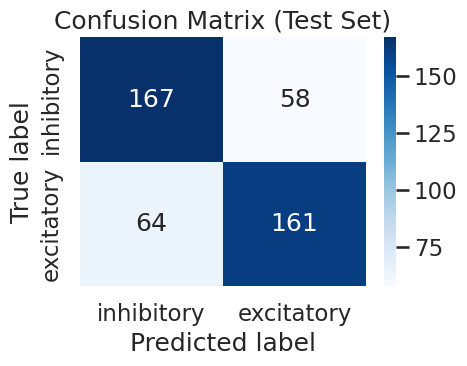

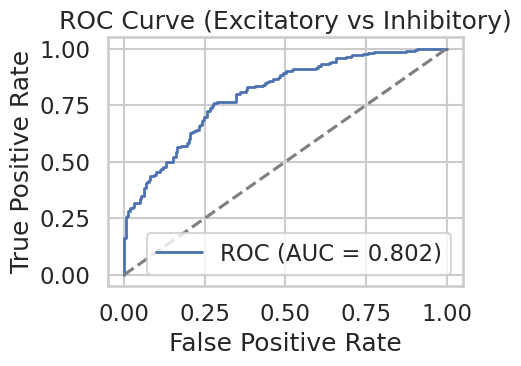

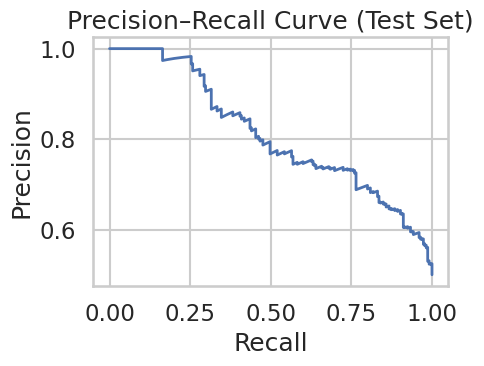

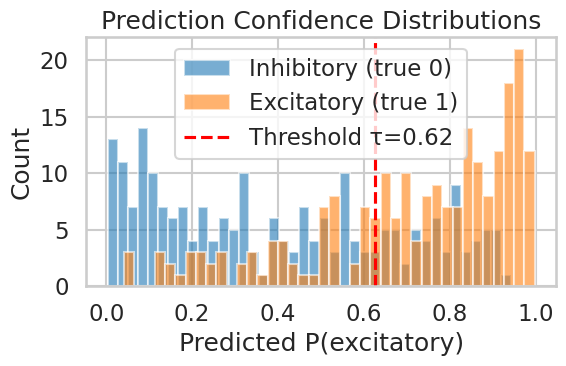

✅ Figures saved to: /content/drive/MyDrive/synapse_resnet2d_figures


In [ ]:
# ================= CELL 12 — Visual diagnostics (CM, ROC, PR, confidence histograms) =================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# ---------- settings ----------
FIG_DIR = "/content/drive/MyDrive/synapse_resnet2d_figures"
os.makedirs(FIG_DIR, exist_ok=True)

sns.set(style="whitegrid", context="talk")

# ---------- 1) Confusion matrix heatmap ----------
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[idx_to_class[0], idx_to_class[1]],
    yticklabels=[idx_to_class[0], idx_to_class[1]],
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/confusion_matrix.png", dpi=200)
plt.show()

# ---------- 2) ROC curve ----------
fpr, tpr, _ = roc_curve(test_y, test_p1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Excitatory vs Inhibitory)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/roc_curve.png", dpi=200)
plt.show()

# ---------- 3) Precision–Recall curve ----------
precision, recall, _ = precision_recall_curve(test_y, test_p1)

plt.figure(figsize=(5, 4))
plt.plot(recall, precision, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Test Set)")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/precision_recall_curve.png", dpi=200)
plt.show()

# ---------- 4) Confidence distribution histogram ----------
plt.figure(figsize=(6, 4))
plt.hist(
    test_p1[test_y == 0],
    bins=40,
    alpha=0.6,
    label="Inhibitory (true 0)",
    color="tab:blue",
)
plt.hist(
    test_p1[test_y == 1],
    bins=40,
    alpha=0.6,
    label="Excitatory (true 1)",
    color="tab:orange",
)
plt.axvline(best_tau, color="red", linestyle="--", label=f"Threshold τ={best_tau:.2f}")
plt.xlabel("Predicted P(excitatory)")
plt.ylabel("Count")
plt.title("Prediction Confidence Distributions")
plt.legend()
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/confidence_histograms.png", dpi=200)
plt.show()

print(f"Figures saved to: {FIG_DIR}")
